<IPython.core.display.Javascript object>


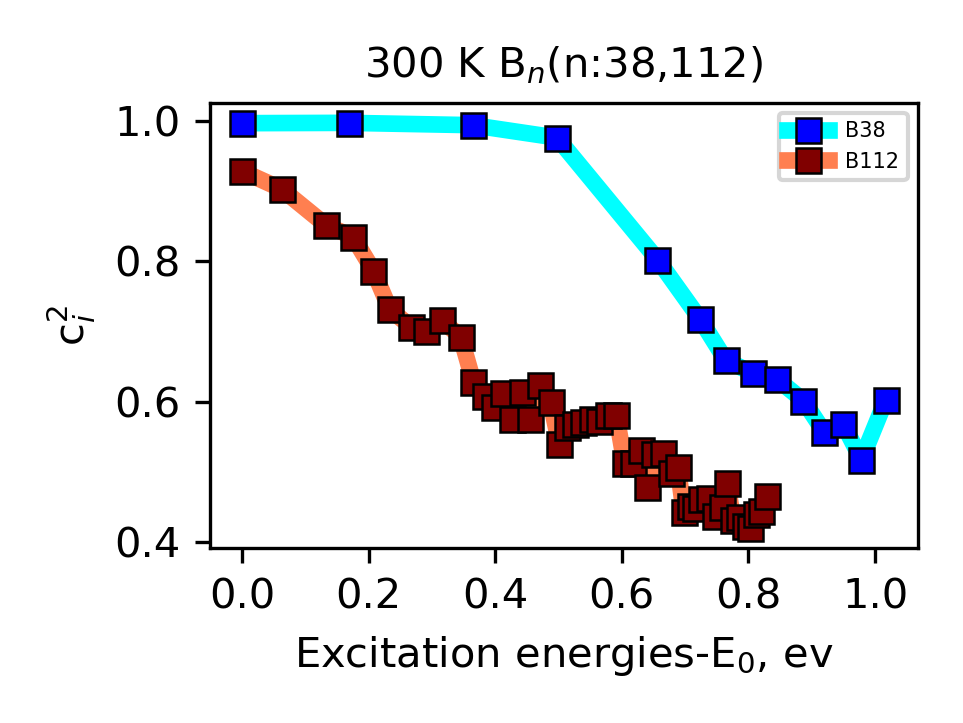

[[0.        ]
 [0.16868225]
 [0.36446595]
 [0.49754275]
 [0.6563241 ]
 [0.72314565]
 [0.76396795]
 [0.80720235]
 [0.8447047 ]
 [0.8867301 ]
 [0.9196729 ]
 [0.94927855]
 [0.97840505]
 [1.0168735 ]]
[[0.        ]
 [0.06300854]
 [0.1328896 ]
 [0.17552291]
 [0.20759869]
 [0.23359553]
 [0.26779538]
 [0.29138417]
 [0.31544799]
 [0.34541568]
 [0.36566663]
 [0.38375161]
 [0.39865392]
 [0.41250055]
 [0.42645337]
 [0.44208307]
 [0.45491583]
 [0.47078437]
 [0.48752894]
 [0.50143809]
 [0.51411291]
 [0.52589045]
 [0.53790809]
 [0.55218226]
 [0.56443508]
 [0.57866216]
 [0.59143095]
 [0.60429317]
 [0.61795151]
 [0.62962226]
 [0.6402095 ]
 [0.65107417]
 [0.66557759]
 [0.67735829]
 [0.6883102 ]
 [0.69769693]
 [0.70742889]
 [0.7158507 ]
 [0.72547271]
 [0.7371492 ]
 [0.74786442]
 [0.75783854]
 [0.76661719]
 [0.77574794]
 [0.7850206 ]
 [0.79427211]
 [0.8027297 ]
 [0.81237422]
 [0.81984548]
 [0.82930347]]


In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

def read_cp2k_tddfpt_log_file( params ):
    # Critical parameters
    critical_params = [ "logfile_name", "number_of_states" ]
    # Default parameters
    default_params = { "tolerance":0.05, "isUKS": 0}
    # Check input
    #comn.check_input(params, default_params, critical_params)
    
    logfile_name = params["logfile_name"]
    number_of_states = int(params["number_of_states"])
    tolerance = float(params["tolerance"])
    isUKS = int(params["isUKS"])


    f = open( logfile_name, 'r' )
    lines = f.readlines()
    f.close()

    for i in range( 0, len(lines) ):
        tmp_line = lines[i].lower().split()
        if 'excitation' in tmp_line:
            if 'analysis' in tmp_line:

                # When found the line in which contains 'Excitation analysis' in 
                # the log file, append it in the variable exc_anal_line
                exc_anal_line = i

        if 'states' in tmp_line:
            if 'multiplicity' in tmp_line:

                # Here we search for the line that contains 'R-TDDFPT states of multiplicity 1'
                # or 'U-TDDFPT states of multiplicity 1' in the log file
                r_tddfpt_line = i

    excitation_energies = []

    # Start from 5 lines after finding the line contaning 'R-TDDFPT states of multiplicity 1'
    # This is because they contain the energies from that line.
    for i in range( r_tddfpt_line+5, len( lines ) ):
        tmp_line = lines[i].split()
        if len( tmp_line ) == 0:
            break
        excitation_energies.append( float( tmp_line[2] ) )

    # Start from 5 lines after finding the line contaning 'Excitation analysis'
    # From that point we have the state numbers with their configurations.
    # So, we append the lines which contain only 'State number' and stop
    # whenever we reach to a blank line.
    state_num_lines = []
    for i in range( exc_anal_line+5, len( lines ) ):
        tmp_line = lines[i].split()
        if isUKS == 1:

            if len( tmp_line ) == 0 or '----' in lines[i]:
                state_num_lines.append( i )
                break
            if len( tmp_line )==1 or len( tmp_line )==3:
                state_num_lines.append(i)

        else:

            if len( tmp_line ) == 0 or '----' in lines[i]:
                state_num_lines.append( i )
                break
            if len(lines[i].split())==1:
                state_num_lines.append(i)
            elif len( tmp_line ) > 1:
                if tmp_line[0].isdigit() and not( tmp_line[1].isdigit() ):
                    state_num_lines.append( i )


    # Setting up the CI-basis list and their coefficients list
    ci_basis = []
    ci_coefficients = []
    spin_components = []
    for i in range( number_of_states ):

        # states and their coefficients for each excited state
        tmp_state              = []
        tmp_state_coefficients = []
        tmp_spin = []
        for j in range( state_num_lines[i]+1, state_num_lines[i+1] ):
            
            # Splitting lines[j] into tmp_splitted_line
            tmp_splitted_line = lines[j].split()

            # If we are using the spin-polarized Kohn-Sham basis, then the size of the split line is different
            # from the size of the split line when using the spin-unpolarized Kohn-Sham basis
            if isUKS == 1:

                ci_coefficient = float( tmp_splitted_line[4] )
                if ci_coefficient**2 > tolerance:
                    # We need to remove the paranthesis from the 2nd element of the temporary splitted line
                    tmp_spin.append( tmp_splitted_line[1].replace('(','').replace(')','') )
                    tmp_state.append( [ int( tmp_splitted_line[0] ), int( tmp_splitted_line[2] ) ]  )
                    tmp_state_coefficients.append( ci_coefficient  )

            # Here, we have the spin-unpolarize Kohn-Sham basis
            # For this case, spin-components will just return all alpha
            else:
                ci_coefficient = float( tmp_splitted_line[2] )
                if ci_coefficient**2 > tolerance:
                    tmp_spin.append( "alp" )
                    tmp_state.append( [ int( tmp_splitted_line[0] ), int( tmp_splitted_line[1] ) ]  )
                    tmp_state_coefficients.append( ci_coefficient  )

        # Append the CI-basis and and their coefficients for
        # this state into the ci_basis and ci_coefficients lists
        ci_basis.append( tmp_state )
        ci_coefficients.append( tmp_state_coefficients )
        spin_components.append( tmp_spin )

    return excitation_energies[0:number_of_states], ci_basis, ci_coefficients, spin_components

def normalize_ci_coefficients(ci_coefficients_raw_unnorm):
    """
    This funciton normalizes the list of configuration interaction (CI) coefficients.
    
    Args:
    
        ci_coefficients_raw_unnorm (list): The list containing the lists of unnormalized CI coefficients.
    Returns:
    
        ci_coefficients_raw_norm (list): The list containing the lists of normalized CI coefficients.
    
    """
    # Number of states contributing in the excited state
    nstates = len(ci_coefficients_raw_unnorm)
    # Creating an empty list to store the normalized CI coefficients
    ci_coefficients_raw_norm = []
       
    for i in range(nstates):
        
        #### ordinary way without using numpy
        # Set up an initial parameter to compute the norm of the vector
        norm = 0.0
        # For each list of CI coefficients
        ci_coefficients_raw_norm.append( [] )
        
        for j in ci_coefficients_raw_unnorm[i]:
            # sum of CI coefficients square
            norm += j*j
        # Compute the norm by taking the square root of the sum to compute the norm
        norm = math.sqrt(norm)
        
        # numpy way to compute the normalized CI coefficients
        ci_coefficients_raw_unnorm[i] = np.array(ci_coefficients_raw_unnorm[i])
        ci_coefficients_raw_norm[i]   = ci_coefficients_raw_unnorm[i] / norm
        ci_coefficients_raw_norm[i]   = list(ci_coefficients_raw_norm[i]) 
    
    return ci_coefficients_raw_norm


def scalar_stat(data):
    """
    The function computes some simple descriptive statistics of the scalar data series.
    Args:
        data ( list of doubles ): the data to be analyzed
    Returns:
        tuple: (res, res2), where:
            * res ( double ): average of data
            * res2 ( double ): standard deviation of data
    """

    N = len(data)
    res = 0.0

    #===== Average ====
    for i in range(0,N):
        res = res + data[i]
    res = res / float(N)

    #===== Std ========
    res2 = 0.0
    
    for i in range(0,N):
        res2 = res2 + (data[i] - res)**2
    res2 = math.sqrt( res2 / float(N) )

    return res, res2
    
    
%matplotlib notebook
params_mb_sd = {}
params_mb_sd["logfile_directory"] = '/mnt/c/Users/asus/Desktop/WD/excitation analysis/all-logfiles'
params_mb_sd["isUKS"] = False
params_mb_sd["tolerance"] = 0.01
#params_mb_sd["number_of_states"] = 50#50
plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)
#******************************************************************************************************************
params_mb_sd["number_of_states"] = 14#10
logfiles = glob.glob(F"{params_mb_sd['logfile_directory']}/out-B38*.log")
#print(logfiles)
#print(logfiles)
params = params_mb_sd
nsds = 3
colors = ['cyan','maroon','gray']#,'purple']
ci_coeffs = []
all_energies=[]

for logfile in logfiles:
    params.update({"logfile_name": logfile})
    excitation_energies, ci_basis_raw, ci_coefficients_raw_unnorm, spin_components = read_cp2k_tddfpt_log_file( params ) 
    all_energies.append(excitation_energies)
    #print(excitation_energies)
    #print()
    ci_coefficients_raw_norm = normalize_ci_coefficients(ci_coefficients_raw_unnorm)
    for j in range(len(ci_coefficients_raw_norm)):
        for k in range(len(ci_coefficients_raw_norm[j])):
            ci_coefficients_raw_norm[j][k] = ci_coefficients_raw_norm[j][k]**2
    ci_coeffs.append(ci_coefficients_raw_norm)
#df['mean'] = df.mean(axis=1)
#print(all_energies)
E=pd.DataFrame(all_energies)
#print(E)
#print()
E=E.mean(axis=0)   
excitation_energies=pd.DataFrame(E).to_numpy()
#excitation_energies=E.values.tolist()
#print(excitation_energies)
nsteps = len(ci_coeffs)
nstates = params["number_of_states"]

coeffs = []
coeffs_avg   = []
coeffs_error = []
B=[]
#A= np.array(A)
A=[]
C=[]
#D=np.c_[C]
for state in range(nstates):

    coeffs.append( [] )
    coeffs_avg.append( [] )
    coeffs_error.append( [] )

    for sd in range( nsds ):

        coeffs[state].append( [] )
        coeffs_avg[state].append( [] )
        coeffs_error[state].append( [] )
        
        

        for step in range( nsteps ):
            if len( ci_coeffs[step][state] ) < nsds and sd > len( ci_coeffs[step][state] )-1:
                coeffs[state][sd].append( 0.0 )
            else:
                coeffs[state][sd].append( ci_coeffs[step][state][sd] )
     
        mb_coeff_avg, mb_coeff_std = scalar_stat( coeffs[state][sd] )
        coeffs_avg[state][sd].append( mb_coeff_avg )
        coeffs_error[state][sd].append( 1.96 * mb_coeff_std / math.sqrt(nsteps) )
        #print(mb_coeff_std)
        if sd==1:
            B.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')
        
        elif sd==2:
            A.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')
        
        else:
            C.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')

#plt.plot(  excitation_energies-excitation_energies[0], A,label='B38', color="cyan", linewidth=4, marker='s',markeredgecolor='black', markerfacecolor='blue',  markeredgewidth=0.6, markersize=6)
#plt.plot(  excitation_energies-excitation_energies[0], B,label='B38', color="cyan", linewidth=4,marker='s',markeredgecolor='black', markerfacecolor='blue',  markeredgewidth=0.6, markersize=6)
plt.plot(  excitation_energies-excitation_energies[0], C,label='B38', color="cyan",linewidth=4, marker='s',markeredgecolor='black', markerfacecolor='blue',  markeredgewidth=0.6, markersize=6)

print( excitation_energies-excitation_energies[0])

#******************************************************************************************************************
params_mb_sd["number_of_states"] = 50#50
logfiles = glob.glob(F"{params_mb_sd['logfile_directory']}/out-B112*.log")
#print(logfiles)
#print(logfiles)
params = params_mb_sd
nsds = 3
colors = ['cyan','maroon','gray']#,'purple']
ci_coeffs = []
all_energies=[]

for logfile in logfiles:
    params.update({"logfile_name": logfile})
    excitation_energies, ci_basis_raw, ci_coefficients_raw_unnorm, spin_components = read_cp2k_tddfpt_log_file( params ) 
    all_energies.append(excitation_energies)
    #print(excitation_energies)
    #print()
    ci_coefficients_raw_norm = normalize_ci_coefficients(ci_coefficients_raw_unnorm)
    for j in range(len(ci_coefficients_raw_norm)):
        for k in range(len(ci_coefficients_raw_norm[j])):
            ci_coefficients_raw_norm[j][k] = ci_coefficients_raw_norm[j][k]**2
    ci_coeffs.append(ci_coefficients_raw_norm)
#df['mean'] = df.mean(axis=1)
#print(all_energies)
E=pd.DataFrame(all_energies)
#print(E)
#print()
E=E.mean(axis=0)   
excitation_energies=pd.DataFrame(E).to_numpy()
#excitation_energies=E.values.tolist()
#print(excitation_energies)
nsteps = len(ci_coeffs)
nstates = params["number_of_states"]

coeffs = []
coeffs_avg   = []
coeffs_error = []
B=[]
#A= np.array(A)
A=[]
C=[]
#D=np.c_[C]
for state in range(nstates):

    coeffs.append( [] )
    coeffs_avg.append( [] )
    coeffs_error.append( [] )

    for sd in range( nsds ):

        coeffs[state].append( [] )
        coeffs_avg[state].append( [] )
        coeffs_error[state].append( [] )
        
        

        for step in range( nsteps ):
            if len( ci_coeffs[step][state] ) < nsds and sd > len( ci_coeffs[step][state] )-1:
                coeffs[state][sd].append( 0.0 )
            else:
                coeffs[state][sd].append( ci_coeffs[step][state][sd] )
     
        mb_coeff_avg, mb_coeff_std = scalar_stat( coeffs[state][sd] )
        coeffs_avg[state][sd].append( mb_coeff_avg )
        coeffs_error[state][sd].append( 1.96 * mb_coeff_std / math.sqrt(nsteps) )
        #print(mb_coeff_std)
        if sd==1:
            B.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')
        
        elif sd==2:
            A.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')
        
        else:
            C.append(mb_coeff_avg)
           # plt.errorbar( excitation_energies[state], mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')
#plt.plot(  excitation_energies-excitation_energies[0], A,label='B112', color="coral", linewidth=4, marker='s',markeredgecolor='black', markerfacecolor='maroon',  markeredgewidth=0.6, markersize=6)
#plt.plot(  excitation_energies-excitation_energies[0], B,label='B112', color="coral", linewidth=4,marker='s',markeredgecolor='black', markerfacecolor='maroon',  markeredgewidth=0.6, markersize=6)
plt.plot(  excitation_energies-excitation_energies[0], C,label='B112', color="coral",linewidth=4, marker='s',markeredgecolor='black', markerfacecolor='maroon',  markeredgewidth=0.6, markersize=6)


print(  excitation_energies-excitation_energies[0])
#******************************************************************************************************************



#plt.subplot(1,1,1)

plt.title("300 K B$_{n}$(n:38,112)", fontsize=10)

plt.legend(fontsize=5, ncol=1, loc='best')
plt.xlabel('Excitation energies-E$_0$, ev')
plt.ylabel('c$_{i}^2$')
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.tight_layout()
plt.savefig('B(38-112)-e-e0-C.png', dpi=500)
#plt.savefig('Bn_excitation_analysis_0K.png', dpi=300)
plt.show()        
